In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras import Sequential
from keras.src.layers import LSTM, Dense
import joblib

In [45]:
def get_df(data_size:int=10000, path:str="AAPL_stock_prices.csv", delimeter: str = ',', from_end: bool = True, date_column: str = 'Date', target_column: str = 'Close') -> tuple[np.ndarray, MinMaxScaler, int]:
    df = pd.read_csv(path, delimiter=delimeter)
    df = df.iloc[-data_size:, :] if from_end else df.iloc[:data_size, :]
    dates = pd.to_datetime(df[date_column])
    df.drop(columns=[date_column], inplace=True)
    df.index = dates # type: ignore
    target_column_index = df.columns.tolist().index(target_column)

    try: 
        scaler = joblib.load('scaler.gz')
    except:
        scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler, target_column_index

scaled_data, scaler, target_column_index = get_df()



In [4]:
def get_df(df: pd.DataFrame, scaler = None, target_column: str = 'Close'):
    target_column_index = df.columns.tolist().index(target_column)
    if scaler is None:
        try: 
            scaler = joblib.load('scaler.gz')
        except:
            scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, target_column_index

In [5]:
def create_dataset(data: np.ndarray, time_step: int=10):
    X, Y = [], []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Define the range of output sequences
        out_end_ix = end_ix + 1
        
        # Ensure that the dataset is within bounds
        if out_end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[out_end_ix]
        
        # Append the parts
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y), data.shape[1], time_step


X, Y, feature_number, time_step = create_dataset(data=scaled_data)

(9989, 10, 6)
(9989, 6)


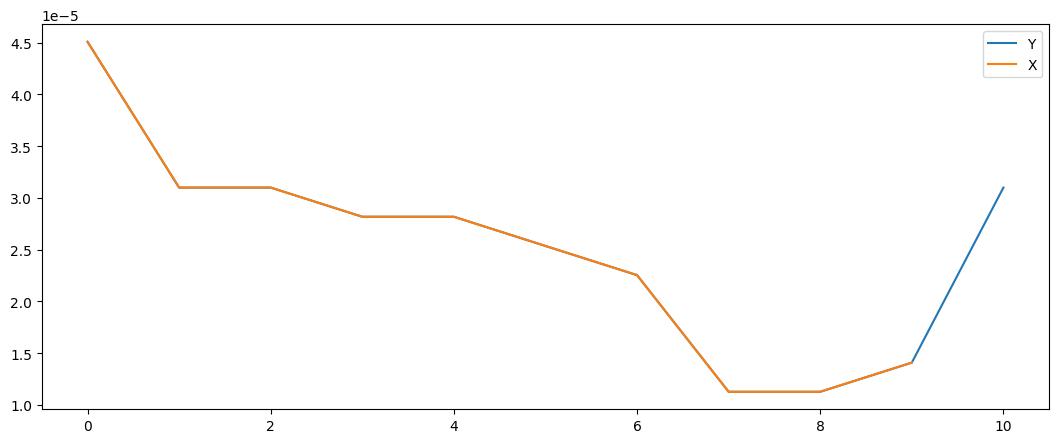

In [6]:
# Plot X and Y
print(X.shape)
print(Y.shape)
for i in range(250,251):
    plot_X, plot_all = [], []
    for value in range(X.shape[1]):
      plot_X.append(X[i, value, target_column_index])
      plot_all.append(X[i, value, target_column_index])
    plot_all.append(Y[i, target_column_index])

    plt.figure(figsize=(13, 5))
    plt.plot(plot_all, label='Y')
    plt.plot(plot_X, label='X')
    plt.legend()
    plt.show()

In [7]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [8]:
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")
print(X_train[:1, 0, :])
print(X_test[:1, 0, :])
print(Y_train[:1, :])
print(Y_test[:1, :])

X_train.shape=(6992, 10, 6), Y_train.shape=(6992, 6)
X_test.shape=(2997, 10, 6), Y_test.shape=(2997, 6)
[[0.00025089 0.00024888 0.00025502 0.00025359 0.00019622 0.01395463]]
[[0.10492513 0.10526256 0.10541671 0.10560312 0.08953514 0.0483887 ]]
[[0.00020579 0.00020414 0.00018135 0.00018597 0.0001439  0.03550249]]
[[0.10802107 0.1096187  0.10841806 0.10966603 0.09297894 0.06496435]]


In [26]:
def create_model(input_shape: tuple, layers_with_units: list[int] = [128,128,64], optimizer: str = 'adam', loss: str = 'mean_squared_error', metrics: list[str]=['mse', 'mape']) -> Sequential:
    # Create the LSTM model
    model = Sequential()
    for layer in layers_with_units[:-1]:
        model.add(LSTM(layer, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(layers_with_units[-1], return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss = loss, metrics=metrics)
    return model

In [31]:
EPOCH: int = 100
BATCH_SIZE: int = 4
LAYERS: list[int] = [256,256]
OPTIMIZER: str = 'adam'
LOSS: str = 'mean_squared_error'
METRICS: list[str] = ['mse']

In [32]:
model = create_model(input_shape=(X_train.shape[1], feature_number), layers_with_units=LAYERS, optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [33]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - loss: 6.6838e-04 - mse: 6.6838e-04 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 2/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - loss: 6.9577e-04 - mse: 6.9577e-04 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 3/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - loss: 6.2291e-04 - mse: 6.2291e-04 - val_loss: 0.0640 - val_mse: 0.0640
Epoch 4/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - loss: 6.8915e-04 - mse: 6.8915e-04 - val_loss: 0.0734 - val_mse: 0.0734
Epoch 5/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - loss: 6.3489e-04 - mse: 6.3489e-04 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 6/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - loss: 6.1523e-04 - mse: 6.1523e-04 - val_loss: 0.0663 - val_mse: 0.0663
Epoch 7/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - loss: 6.6893e-04 - mse: 6.6893e-04 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 8/100
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - loss: 6.1876e-04 - mse: 

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


C:\Users\orhun\AppData\Local\Temp\ipykernel_3116\2027912005.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


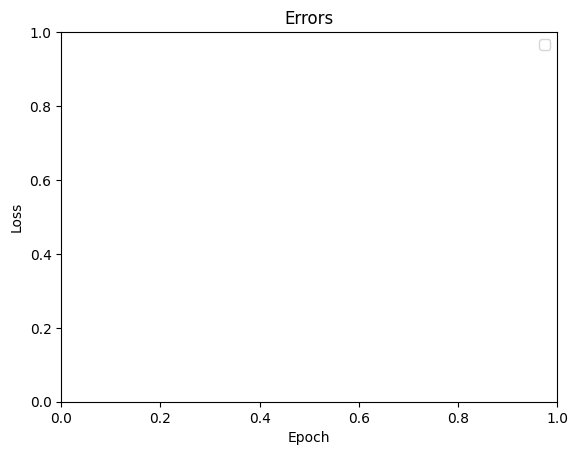

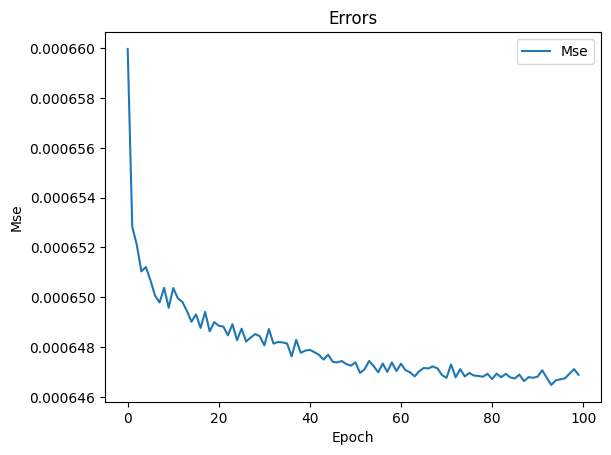

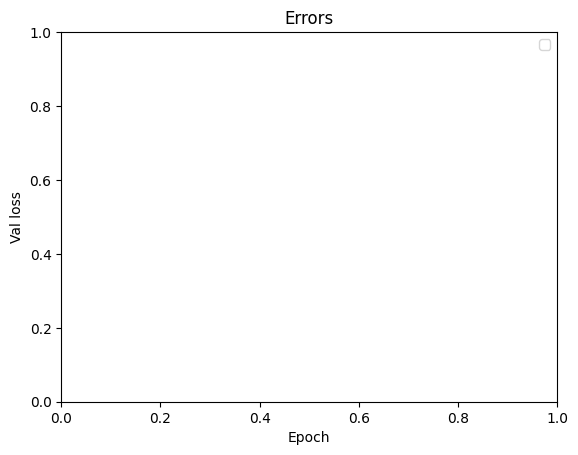

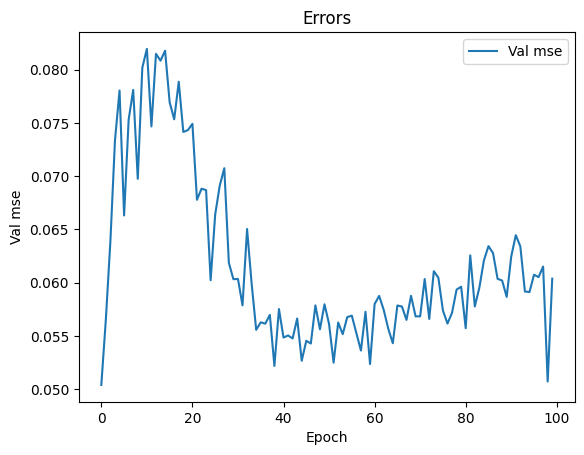

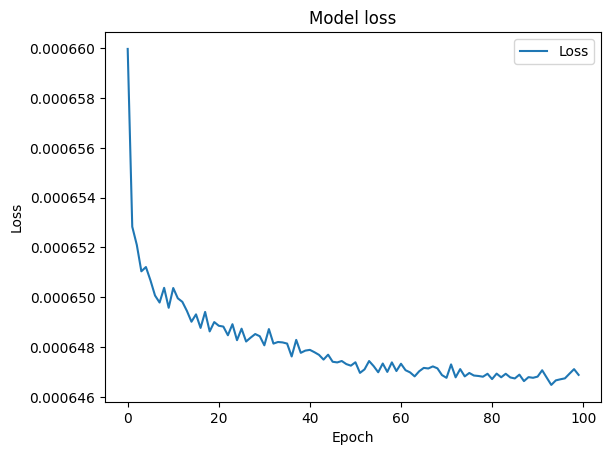

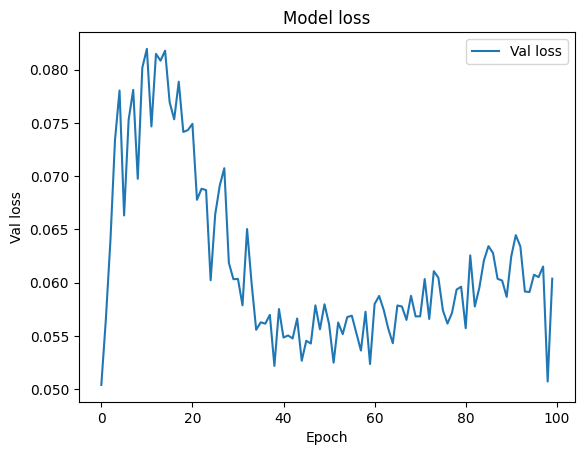

In [34]:
# Plot training & validation loss values
print(history.history.keys())
other_keys: list = []
for value in history.history.keys() :
    plt.plot(history.history[value], label=value.replace('_', ' ').capitalize()) if not 'loss' in value and not 'acc' in value else other_keys.append(value)
    plt.title('Errors')
    plt.ylabel(value.replace('_', ' ').capitalize())
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
for value in other_keys :
    plt.plot(history.history[value], label=value.replace('_', ' ').capitalize())
    plt.title('Model loss')
    plt.ylabel(value.replace('_', ' ').capitalize())
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [35]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [36]:
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
# print(train_predict[:2, :])

train_predict.shape=(6992, 1), test_predict.shape=(2997, 1), Y_train.shape=(6992, 6), Y_test.shape=(2997, 6)


In [37]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int, feature_number: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [38]:
train_predict = update_data_to_inverse(predicted_data=train_predict, scaler=scaler, target_column_index=target_column_index, feature_number=feature_number)
test_predict = update_data_to_inverse(predicted_data=test_predict, scaler=scaler, target_column_index=target_column_index, feature_number=feature_number)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[:2, :])

train_predict.shape=(6992, 1), test_predict.shape=(2997, 1), Y_train.shape=(6992, 6), Y_test.shape=(2997, 6)
[[1.21620999]
 [1.10243587]]


In [39]:
# Calculate MSE
train_mse = mean_squared_error(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_mse = mean_squared_error(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

# Calculate R2 score
train_r2 = r2_score(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_r2 = r2_score(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")
print(f"\nTrue - Y_train[5:10, target_column_index].reshape(-1, 1)\n{Y_train[5:10, target_column_index].reshape(-1, 1)}\n\nPredicted - train_predict[5:10]\n{train_predict[5:10]}")

Train MSE: 3.5446, Test MSE: 2457.8925
Train R2 Score: 0.7653, Test R2 Score: 0.2886

True - Y_train[5:10, target_column_index].reshape(-1, 1)
[[0.114397]
 [0.113281]
 [0.116071]
 [0.117188]
 [0.112723]]

Predicted - train_predict[5:10]
[[1.14026092]
 [1.21552681]
 [1.33202645]
 [1.16071539]
 [1.25888517]]


In [40]:
def log(epoch, layers_with_units, optimizer, loss, train_mse = None, train_r2 = None, y_true = None, train_predict = None):
    with open('log.txt', 'a') as file:
        file.write(f"Train Results with Epoch - {epoch}:")
        if y_true and train_predict:
            file.write(f"\nY_True:\n{y_true}\nY_Predicted\n{train_predict}")        
        file.write(f"\n    Layers: {layers_with_units}")
        file.write(f"\n    Optimizer : {optimizer}")
        file.write(f"\n    Loss: {loss}")
        file.write(f"\n    Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
        file.write(f"\n    Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}\n\n")

In [41]:
# log(epoch=EPOCH, layers_with_units=LAYERS, optimizer=OPTIMIZER, loss=LOSS, train_mse=train_mse, train_r2=train_r2, y_true=Y_train[5:10, target_column_index].reshape(-1, 1), train_predict=train_predict[5:10])
log(epoch=EPOCH, layers_with_units=LAYERS, optimizer=OPTIMIZER, loss=LOSS, train_mse=train_mse, train_r2=train_r2)

time_step=10, X.shape=(9989, 10, 6), (len(train_predict) + time_step)=7002
test_predict.shape=(2997, 1), train_predict.shape=(6992, 1), scaled_data.shape=(10000, 6)


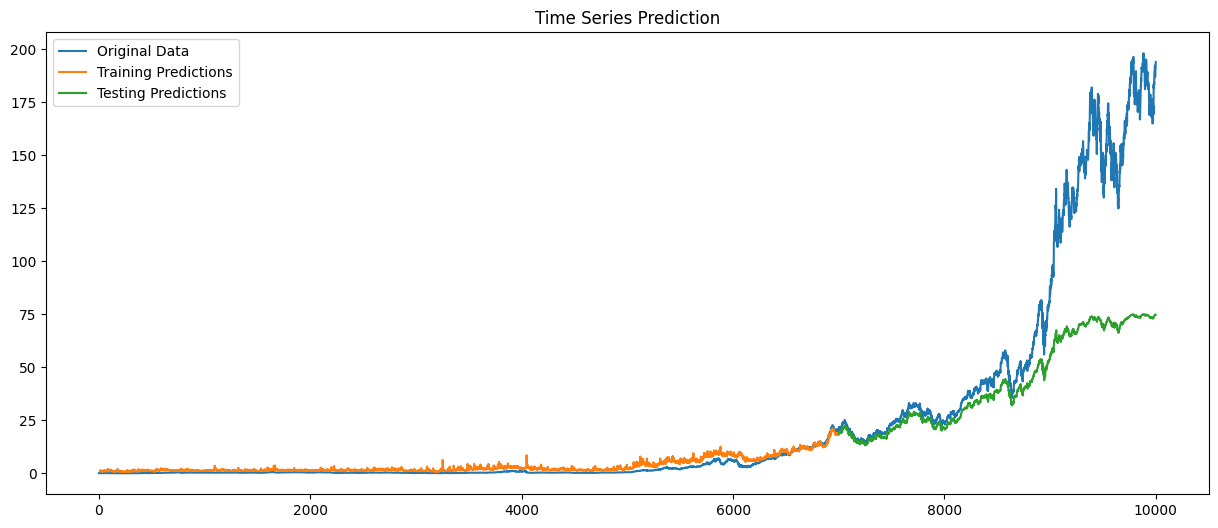

In [42]:
print(f"{time_step=}, {X.shape=}, {(len(train_predict) + time_step)=}")
print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")

# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data)[:, target_column_index], label='Original Data')
train_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Training Predictions')

test_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + time_step:len(scaled_data[:, target_column_index]) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Testing Predictions')

plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [43]:
joblib.dump(scaler, 'scaler.gz')

['scaler.gz']

In [44]:
model.save('lstm_model_test.h5')

In [ ]:
# # Load the saved model
# loaded_model = load_model('lstm_model.h5')

In [ ]:
# # Assuming `X_new` and `Y_new` are new data arrays
# history_updated = loaded_model.fit(X_new, Y_new, epochs=50, batch_size=1, verbose=1)

# # Save the updated model
# loaded_model.save('updated_lstm_model.h5')